# `DataFrame` objects
A DataFrame object represents a spreadsheet, with cell values, column names and row index labels. You can define expressions to compute columns based on other columns, create pivot-tables, group rows, draw graphs, etc. You can see `DataFrame`s as dictionaries of `Series`.

## Creating a `DataFrame`
You can create a DataFrame by passing a dictionary of `Series` objects:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
people_dict = {
    "weight": pd.Series([68, 83, 112], index=["alice", "bob", "charles"]),
    "birthyear": pd.Series([1984, 1985, 1992], index=["bob", "alice", "charles"], name="year"),
    "children": pd.Series([0, 3], index=["charles", "bob"]),
    "hobby": pd.Series(["Biking", "Dancing"], index=["alice", "bob"]),
}
people = pd.DataFrame(people_dict)
people

weight  birthyear  children    hobby
alice        68       1985       NaN   Biking
bob          83       1984       3.0  Dancing
charles     112       1992       0.0      NaN

A few things to note:
* the `Series` were automatically aligned based on their index,
* missing values are represented as `NaN`,
* `Series` names are ignored (the name `"year"` was dropped),
* `DataFrame`s are displayed nicely in Jupyter notebooks, woohoo!

You can access columns pretty much as you would expect. They are returned as `Series` objects:

In [3]:
people["birthyear"]

alice      1985
bob        1984
charles    1992
Name: birthyear, dtype: int64

You can also get multiple columns at once:

In [4]:
people[["birthyear", "hobby"]]

birthyear    hobby
alice         1985   Biking
bob           1984  Dancing
charles       1992      NaN

If you pass a list of columns and/or index row labels to the `DataFrame` constructor, it will guarantee that these columns and/or rows will exist, in that order, and no other column/row will exist. For example:

In [5]:
d2 = pd.DataFrame(
    people_dict, columns=["birthyear", "weight", "height"], index=["bob", "alice", "eugene"]
)
d2

birthyear  weight height
bob        1984.0    83.0    NaN
alice      1985.0    68.0    NaN
eugene        NaN     NaN    NaN

Another convenient way to create a `DataFrame` is to pass all the values to the constructor as an `ndarray`, or a list of lists, and specify the column names and row index labels separately:

In [6]:
values = [[1985, np.nan, "Biking", 68], [1984, 3, "Dancing", 83], [1992, 0, np.nan, 112]]
d3 = pd.DataFrame(
    values, columns=["birthyear", "children", "hobby", "weight"], index=["alice", "bob", "charles"]
)
d3

birthyear  children    hobby  weight
alice         1985       NaN   Biking      68
bob           1984       3.0  Dancing      83
charles       1992       0.0      NaN     112

To specify missing values, you can either use `np.nan` or NumPy's masked arrays:

In [7]:
masked_array = np.ma.asarray(values, dtype=np.object)
masked_array[(0, 2), (1, 2)] = np.ma.masked
d3 = pd.DataFrame(
    masked_array,
    columns=["birthyear", "children", "hobby", "weight"],
    index=["alice", "bob", "charles"],
)
d3

birthyear children    hobby weight
alice        1985      NaN   Biking     68
bob          1984        3  Dancing     83
charles      1992        0      NaN    112

Instead of an `ndarray`, you can also pass a `DataFrame` object:

In [8]:
d4 = pd.DataFrame(d3, columns=["hobby", "children"], index=["alice", "bob"])
d4

hobby children
alice   Biking      NaN
bob    Dancing        3

It is also possible to create a `DataFrame` with a dictionary (or list) of dictionaries (or list):

In [9]:
people = pd.DataFrame(
    {
        "birthyear": {"alice": 1985, "bob": 1984, "charles": 1992},
        "hobby": {"alice": "Biking", "bob": "Dancing"},
        "weight": {"alice": 68, "bob": 83, "charles": 112},
        "children": {"bob": 3, "charles": 0},
    }
)
people

birthyear    hobby  weight  children
alice         1985   Biking      68       NaN
bob           1984  Dancing      83       3.0
charles       1992      NaN     112       0.0

## Multi-indexing
If all columns are tuples of the same size, then they are understood as a multi-index. The same goes for row index labels. For example:

In [10]:
d5 = pd.DataFrame(
    {
        ("public", "birthyear"): {
            ("Paris", "alice"): 1985,
            ("Paris", "bob"): 1984,
            ("London", "charles"): 1992,
        },
        ("public", "hobby"): {("Paris", "alice"): "Biking", ("Paris", "bob"): "Dancing"},
        ("private", "weight"): {
            ("Paris", "alice"): 68,
            ("Paris", "bob"): 83,
            ("London", "charles"): 112,
        },
        ("private", "children"): {
            ("Paris", "alice"): np.nan,
            ("Paris", "bob"): 3,
            ("London", "charles"): 0,
        },
    }
)
d5

public          private         
               birthyear    hobby  weight children
Paris  alice        1985   Biking      68      NaN
       bob          1984  Dancing      83      3.0
London charles      1992      NaN     112      0.0

You can now get a `DataFrame` containing all the `"public"` columns very simply:

In [11]:
d5["public"]

birthyear    hobby
Paris  alice         1985   Biking
       bob           1984  Dancing
London charles       1992      NaN

In [12]:
d5["public", "hobby"]  # Same result as d5["public"]["hobby"]

Paris   alice       Biking
        bob        Dancing
London  charles        NaN
Name: (public, hobby), dtype: object

## Dropping a level
Let's look at `d5` again:

In [13]:
d5

public          private         
               birthyear    hobby  weight children
Paris  alice        1985   Biking      68      NaN
       bob          1984  Dancing      83      3.0
London charles      1992      NaN     112      0.0

There are two levels of columns, and two levels of indices. We can drop a column level by calling `droplevel()` (the same goes for indices):

In [14]:
d5.columns = d5.columns.droplevel(level=0)
d5

birthyear    hobby  weight  children
Paris  alice         1985   Biking      68       NaN
       bob           1984  Dancing      83       3.0
London charles       1992      NaN     112       0.0

## Transposing
You can swap columns and indices using the `T` attribute:

In [15]:
d6 = d5.T
d6

Paris           London
            alice      bob charles
birthyear    1985     1984    1992
hobby      Biking  Dancing     NaN
weight         68       83     112
children      NaN      3.0     0.0

## Stacking and unstacking levels
Calling the `stack()` method will push the lowest column level after the lowest index:

In [16]:
d7 = d6.stack()
d7

London    Paris
birthyear alice      NaN     1985
          bob        NaN     1984
          charles   1992      NaN
hobby     alice      NaN   Biking
          bob        NaN  Dancing
weight    alice      NaN       68
          bob        NaN       83
          charles    112      NaN
children  bob        NaN      3.0
          charles    0.0      NaN

Note that many `NaN` values appeared. This makes sense because many new combinations did not exist before (eg. there was no `bob` in `London`).

Calling `unstack()` will do the reverse, once again creating many `NaN` values.

In [17]:
d8 = d7.unstack()
d8

London                Paris                 
           alice  bob charles   alice      bob charles
birthyear    NaN  NaN    1992    1985     1984     NaN
children     NaN  NaN     0.0     NaN      3.0     NaN
hobby        NaN  NaN     NaN  Biking  Dancing     NaN
weight       NaN  NaN     112      68       83     NaN

If we call `unstack` again, we end up with a `Series` object:

In [18]:
d9 = d8.unstack()
d9

London  alice    birthyear        NaN
                 children         NaN
                 hobby            NaN
                 weight           NaN
        bob      birthyear        NaN
                 children         NaN
                 hobby            NaN
                 weight           NaN
        charles  birthyear       1992
                 children         0.0
                 hobby            NaN
                 weight           112
Paris   alice    birthyear       1985
                 children         NaN
                 hobby         Biking
                 weight            68
        bob      birthyear       1984
                 children         3.0
                 hobby        Dancing
                 weight            83
        charles  birthyear        NaN
                 children         NaN
                 hobby            NaN
                 weight           NaN
dtype: object

The `stack()` and `unstack()` methods let you select the `level` to stack/unstack. You can even stack/unstack multiple levels at once:

In [19]:
d10 = d9.unstack(level=(0, 1))
d10

London                Paris                 
           alice  bob charles   alice      bob charles
birthyear    NaN  NaN    1992    1985     1984     NaN
children     NaN  NaN     0.0     NaN      3.0     NaN
hobby        NaN  NaN     NaN  Biking  Dancing     NaN
weight       NaN  NaN     112      68       83     NaN

## Most methods return modified copies
As you may have noticed, the `stack()` and `unstack()` methods do not modify the object they apply to. Instead, they work on a copy and return that copy. This is true of most methods in pandas.

## Accessing rows
Let's go back to the `people` `DataFrame`:

In [20]:
people

birthyear    hobby  weight  children
alice         1985   Biking      68       NaN
bob           1984  Dancing      83       3.0
charles       1992      NaN     112       0.0

The `loc` attribute lets you access rows instead of columns. The result is a `Series` object in which the `DataFrame`'s column names are mapped to row index labels:

In [21]:
people.loc["charles"]

birthyear    1992
hobby         NaN
weight        112
children      0.0
Name: charles, dtype: object

You can also access rows by integer location using the `iloc` attribute:

In [22]:
people.iloc[2]

birthyear    1992
hobby         NaN
weight        112
children      0.0
Name: charles, dtype: object

You can also get a slice of rows, and this returns a `DataFrame` object:

In [23]:
people.iloc[1:3]

birthyear    hobby  weight  children
bob           1984  Dancing      83       3.0
charles       1992      NaN     112       0.0

Finally, you can pass a boolean array to get the matching rows:

In [24]:
people[np.array([True, False, True])]

birthyear   hobby  weight  children
alice         1985  Biking      68       NaN
charles       1992     NaN     112       0.0

This is most useful when combined with boolean expressions:

In [25]:
people[people["birthyear"] < 1990]

birthyear    hobby  weight  children
alice       1985   Biking      68       NaN
bob         1984  Dancing      83       3.0

## Adding and removing columns
You can generally treat `DataFrame` objects like dictionaries of `Series`, so the following work fine:

In [26]:
people

birthyear    hobby  weight  children
alice         1985   Biking      68       NaN
bob           1984  Dancing      83       3.0
charles       1992      NaN     112       0.0

In [27]:
people["age"] = 2018 - people["birthyear"]  # adds a new column "age"
people["over 30"] = people["age"] > 30  # adds another column "over 30"
birthyears = people.pop("birthyear")
del people["children"]

people

hobby  weight  age  over 30
alice     Biking      68   33     True
bob      Dancing      83   34     True
charles      NaN     112   26    False

In [28]:
birthyears

alice      1985
bob        1984
charles    1992
Name: birthyear, dtype: int64

When you add a new colum, it must have the same number of rows. Missing rows are filled with NaN, and extra rows are ignored:

In [29]:
people["pets"] = pd.Series(
    {"bob": 0, "charles": 5, "eugene": 1}
)  # alice is missing, eugene is ignored
people

hobby  weight  age  over 30  pets
alice     Biking      68   33     True   NaN
bob      Dancing      83   34     True   0.0
charles      NaN     112   26    False   5.0

When adding a new column, it is added at the end (on the right) by default. You can also insert a column anywhere else using the `insert()` method:

In [30]:
people.insert(1, "height", [172, 181, 185])
people

hobby  height  weight  age  over 30  pets
alice     Biking     172      68   33     True   NaN
bob      Dancing     181      83   34     True   0.0
charles      NaN     185     112   26    False   5.0

## Assigning new columns
You can also create new columns by calling the `assign()` method. Note that this returns a new `DataFrame` object, the original is not modified:

In [31]:
people.assign(
    body_mass_index=people["weight"] / (people["height"] / 100) ** 2, has_pets=people["pets"] > 0
)

hobby  height  weight  age  over 30  pets  body_mass_index  \
alice     Biking     172      68   33     True   NaN        22.985398   
bob      Dancing     181      83   34     True   0.0        25.335002   
charles      NaN     185     112   26    False   5.0        32.724617   

         has_pets  
alice       False  
bob         False  
charles      True

Note that you cannot access columns created within the same assignment:

In [32]:
try:
    people.assign(
        body_mass_index=people["weight"] / (people["height"] / 100) ** 2,
        overweight=people["body_mass_index"] > 25,
    )
except KeyError as e:
    print("Key error:", e)

Key error: 'body_mass_index'


The solution is to split this assignment in two consecutive assignments:

In [33]:
d6 = people.assign(body_mass_index=people["weight"] / (people["height"] / 100) ** 2)
d6.assign(overweight=d6["body_mass_index"] > 25)

hobby  height  weight  age  over 30  pets  body_mass_index  \
alice     Biking     172      68   33     True   NaN        22.985398   
bob      Dancing     181      83   34     True   0.0        25.335002   
charles      NaN     185     112   26    False   5.0        32.724617   

         overweight  
alice         False  
bob            True  
charles        True

Having to create a temporary variable `d6` is not very convenient. You may want to just chain the assigment calls, but it does not work because the `people` object is not actually modified by the first assignment:

In [34]:
try:
    (
        people.assign(body_mass_index=people["weight"] / (people["height"] / 100) ** 2).assign(
            overweight=people["body_mass_index"] > 25
        )
    )
except KeyError as e:
    print("Key error:", e)

Key error: 'body_mass_index'


But fear not, there is a simple solution. You can pass a function to the `assign()` method (typically a `lambda` function), and this function will be called with the `DataFrame` as a parameter:

In [35]:
(
    people.assign(body_mass_index=lambda df: df["weight"] / (df["height"] / 100) ** 2).assign(
        overweight=lambda df: df["body_mass_index"] > 25
    )
)

hobby  height  weight  age  over 30  pets  body_mass_index  \
alice     Biking     172      68   33     True   NaN        22.985398   
bob      Dancing     181      83   34     True   0.0        25.335002   
charles      NaN     185     112   26    False   5.0        32.724617   

         overweight  
alice         False  
bob            True  
charles        True

Problem solved!

## Evaluating an expression
A great feature supported by pandas is expression evaluation. This relies on the `numexpr` library which must be installed.

In [36]:
people.eval("weight / (height/100) ** 2 > 25")

alice      False
bob         True
charles     True
dtype: bool

Assignment expressions are also supported. Let's set `inplace=True` to directly modify the `DataFrame` rather than getting a modified copy:

In [37]:
people.eval("body_mass_index = weight / (height/100) ** 2", inplace=True)
people

hobby  height  weight  age  over 30  pets  body_mass_index
alice     Biking     172      68   33     True   NaN        22.985398
bob      Dancing     181      83   34     True   0.0        25.335002
charles      NaN     185     112   26    False   5.0        32.724617

You can use a local or global variable in an expression by prefixing it with `'@'`:

In [38]:
overweight_threshold = 30
people.eval("overweight = body_mass_index > @overweight_threshold", inplace=True)
people

hobby  height  weight  age  over 30  pets  body_mass_index  \
alice     Biking     172      68   33     True   NaN        22.985398   
bob      Dancing     181      83   34     True   0.0        25.335002   
charles      NaN     185     112   26    False   5.0        32.724617   

         overweight  
alice         False  
bob           False  
charles        True

## Querying a `DataFrame`
The `query()` method lets you filter a `DataFrame` based on a query expression:

In [39]:
people.query("age > 30 and pets == 0")

hobby  height  weight  age  over 30  pets  body_mass_index  overweight
bob  Dancing     181      83   34     True   0.0        25.335002       False

## Sorting a `DataFrame`
You can sort a `DataFrame` by calling its `sort_index` method. By default it sorts the rows by their index label, in ascending order, but let's reverse the order:

In [40]:
people.sort_index(ascending=False)

hobby  height  weight  age  over 30  pets  body_mass_index  \
charles      NaN     185     112   26    False   5.0        32.724617   
bob      Dancing     181      83   34     True   0.0        25.335002   
alice     Biking     172      68   33     True   NaN        22.985398   

         overweight  
charles        True  
bob           False  
alice         False

Note that `sort_index` returned a sorted *copy* of the `DataFrame`. To modify `people` directly, we can set the `inplace` argument to `True`. Also, we can sort the columns instead of the rows by setting `axis=1`:

In [41]:
people.sort_index(axis=1, inplace=True)
people

age  body_mass_index  height    hobby  over 30  overweight  pets  \
alice     33        22.985398     172   Biking     True       False   NaN   
bob       34        25.335002     181  Dancing     True       False   0.0   
charles   26        32.724617     185      NaN    False        True   5.0   

         weight  
alice        68  
bob          83  
charles     112

To sort the `DataFrame` by the values instead of the labels, we can use `sort_values` and specify the column to sort by:

In [42]:
people.sort_values(by="age", inplace=True)
people

age  body_mass_index  height    hobby  over 30  overweight  pets  \
charles   26        32.724617     185      NaN    False        True   5.0   
alice     33        22.985398     172   Biking     True       False   NaN   
bob       34        25.335002     181  Dancing     True       False   0.0   

         weight  
charles     112  
alice        68  
bob          83

## Plotting a `DataFrame`
Just like for `Series`, pandas makes it easy to draw nice graphs based on a `DataFrame`.

For example, it is trivial to create a line plot from a `DataFrame`'s data by calling its `plot` method:

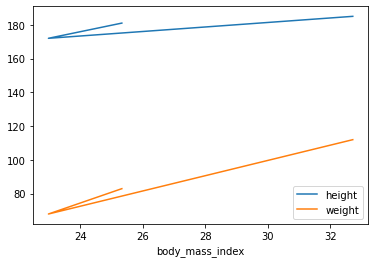

In [43]:
people.plot(kind="line", x="body_mass_index", y=["height", "weight"])
plt.show()

You can pass extra arguments supported by matplotlib's functions. For example, we can create scatterplot and pass it a list of sizes using the `s` argument of matplotlib's `scatter()` function:

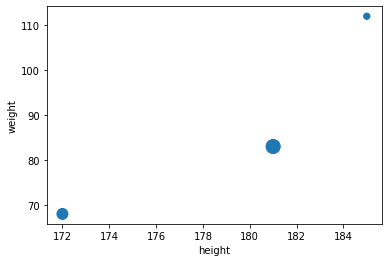

In [44]:
people.plot(kind="scatter", x="height", y="weight", s=[40, 120, 200])
plt.show()

Again, there are way too many options to list here: the best option is to scroll through the [Visualization](http://pandas.pydata.org/pandas-docs/stable/visualization.html) page in pandas' documentation, find the plot you are interested in and look at the example code.

## Operations on `DataFrame`s
Although `DataFrame`s do not try to mimick NumPy arrays, there are a few similarities. Let's create a `DataFrame` to demonstrate this:

In [45]:
grades_array = np.array([[8, 8, 9], [10, 9, 9], [4, 8, 2], [9, 10, 10]])
grades = pd.DataFrame(
    grades_array, columns=["sep", "oct", "nov"], index=["alice", "bob", "charles", "darwin"]
)
grades

sep  oct  nov
alice      8    8    9
bob       10    9    9
charles    4    8    2
darwin     9   10   10

You can apply NumPy mathematical functions on a `DataFrame`: the function is applied to all values:

In [46]:
np.sqrt(grades)

sep       oct       nov
alice    2.828427  2.828427  3.000000
bob      3.162278  3.000000  3.000000
charles  2.000000  2.828427  1.414214
darwin   3.000000  3.162278  3.162278

Similarly, adding a single value to a `DataFrame` will add that value to all elements in the `DataFrame`. This is called *broadcasting*:

In [47]:
grades + 1

sep  oct  nov
alice      9    9   10
bob       11   10   10
charles    5    9    3
darwin    10   11   11

Of course, the same is true for all other binary operations, including arithmetic (`*`,`/`,`**`...) and conditional (`>`, `==`...) operations:

In [48]:
grades >= 5

sep   oct    nov
alice     True  True   True
bob       True  True   True
charles  False  True  False
darwin    True  True   True

Aggregation operations, such as computing the `max`, the `sum` or the `mean` of a `DataFrame`, apply to each column, and you get back a `Series` object:

In [49]:
grades.mean()

sep    7.75
oct    8.75
nov    7.50
dtype: float64

The `all` method is also an aggregation operation: it checks whether all values are `True` or not. Let's see during which months all students got a grade greater than `5`:

In [50]:
(grades > 5).all()

sep    False
oct     True
nov    False
dtype: bool

Most of these functions take an optional `axis` parameter which lets you specify along which axis of the `DataFrame` you want the operation executed. The default is `axis=0`, meaning that the operation is executed vertically (on each column). You can set `axis=1` to execute the operation horizontally (on each row). For example, let's find out which students had all grades greater than `5`:

In [51]:
(grades > 5).all(axis=1)

alice       True
bob         True
charles    False
darwin      True
dtype: bool

The `any` method returns `True` if any value is True. Let's see who got at least one grade 10:

In [52]:
(grades == 10).any(axis=1)

alice      False
bob         True
charles    False
darwin      True
dtype: bool

If you add a `Series` object to a `DataFrame` (or execute any other binary operation), pandas attempts to broadcast the operation to all *rows* in the `DataFrame`. This only works if the `Series` has the same size as the `DataFrame`s rows. For example, let's substract the `mean` of the `DataFrame` (a `Series` object) from the `DataFrame`:

In [53]:
grades - grades.mean()  # equivalent to: grades - [7.75, 8.75, 7.50]

sep   oct  nov
alice    0.25 -0.75  1.5
bob      2.25  0.25  1.5
charles -3.75 -0.75 -5.5
darwin   1.25  1.25  2.5

We substracted `7.75` from all September grades, `8.75` from October grades and `7.50` from November grades. It is equivalent to substracting this `DataFrame`:

In [54]:
pd.DataFrame([[7.75, 8.75, 7.50]] * 4, index=grades.index, columns=grades.columns)

sep   oct  nov
alice    7.75  8.75  7.5
bob      7.75  8.75  7.5
charles  7.75  8.75  7.5
darwin   7.75  8.75  7.5

If you want to substract the global mean from every grade, here is one way to do it:

In [55]:
grades - grades.values.mean()  # substracts the global mean (8.00) from all grades

sep  oct  nov
alice    0.0  0.0  1.0
bob      2.0  1.0  1.0
charles -4.0  0.0 -6.0
darwin   1.0  2.0  2.0

## Automatic alignment
Similar to `Series`, when operating on multiple `DataFrame`s, pandas automatically aligns them by row index label, but also by column names. Let's create a `DataFrame` with bonus points for each person from October to December:

In [56]:
bonus_array = np.array([[0, np.nan, 2], [np.nan, 1, 0], [0, 1, 0], [3, 3, 0]])
bonus_points = pd.DataFrame(
    bonus_array, columns=["oct", "nov", "dec"], index=["bob", "colin", "darwin", "charles"]
)
bonus_points

oct  nov  dec
bob      0.0  NaN  2.0
colin    NaN  1.0  0.0
darwin   0.0  1.0  0.0
charles  3.0  3.0  0.0

In [57]:
grades + bonus_points

dec   nov   oct  sep
alice    NaN   NaN   NaN  NaN
bob      NaN   NaN   9.0  NaN
charles  NaN   5.0  11.0  NaN
colin    NaN   NaN   NaN  NaN
darwin   NaN  11.0  10.0  NaN

Looks like the addition worked in some cases but way too many elements are now empty. That's because when aligning the `DataFrame`s, some columns and rows were only present on one side, and thus they were considered missing on the other side (`NaN`). Then adding `NaN` to a number results in `NaN`, hence the result.

## Handling missing data
Dealing with missing data is a frequent task when working with real life data. Pandas offers a few tools to handle missing data.
 
Let's try to fix the problem above. For example, we can decide that missing data should result in a zero, instead of `NaN`. We can replace all `NaN` values by a any value using the `fillna()` method:

In [58]:
(grades + bonus_points).fillna(0)

dec   nov   oct  sep
alice    0.0   0.0   0.0  0.0
bob      0.0   0.0   9.0  0.0
charles  0.0   5.0  11.0  0.0
colin    0.0   0.0   0.0  0.0
darwin   0.0  11.0  10.0  0.0

It's a bit unfair that we're setting grades to zero in September, though. Perhaps we should decide that missing grades are missing grades, but missing bonus points should be replaced by zeros:

In [59]:
fixed_bonus_points = bonus_points.fillna(0)
fixed_bonus_points.insert(0, "sep", 0)
fixed_bonus_points.loc["alice"] = 0
grades + fixed_bonus_points

dec   nov   oct   sep
alice    NaN   9.0   8.0   8.0
bob      NaN   9.0   9.0  10.0
charles  NaN   5.0  11.0   4.0
colin    NaN   NaN   NaN   NaN
darwin   NaN  11.0  10.0   9.0

That's much better: although we made up some data, we have not been too unfair.

Another way to handle missing data is to interpolate. Let's look at the `bonus_points` `DataFrame` again:

In [60]:
bonus_points

oct  nov  dec
bob      0.0  NaN  2.0
colin    NaN  1.0  0.0
darwin   0.0  1.0  0.0
charles  3.0  3.0  0.0

Now let's call the `interpolate` method. By default, it interpolates vertically (`axis=0`), so let's tell it to interpolate horizontally (`axis=1`).

In [61]:
bonus_points.interpolate(axis=1)

oct  nov  dec
bob      0.0  1.0  2.0
colin    NaN  1.0  0.0
darwin   0.0  1.0  0.0
charles  3.0  3.0  0.0

Bob had 0 bonus points in October, and 2 in December. When we interpolate for November, we get the mean: 1 bonus point. Colin had 1 bonus point in November, but we do not know how many bonus points he had in September, so we cannot interpolate, this is why there is still a missing value in October after interpolation. To fix this, we can set the September bonus points to 0 before interpolation.

In [62]:
better_bonus_points = bonus_points.copy()
better_bonus_points.insert(0, "sep", 0)
better_bonus_points.loc["alice"] = 0
better_bonus_points = better_bonus_points.interpolate(axis=1)
better_bonus_points

sep  oct  nov  dec
bob      0.0  0.0  1.0  2.0
colin    0.0  0.5  1.0  0.0
darwin   0.0  0.0  1.0  0.0
charles  0.0  3.0  3.0  0.0
alice    0.0  0.0  0.0  0.0

Great, now we have reasonable bonus points everywhere. Let's find out the final grades:

In [63]:
grades + better_bonus_points

dec   nov   oct   sep
alice    NaN   9.0   8.0   8.0
bob      NaN  10.0   9.0  10.0
charles  NaN   5.0  11.0   4.0
colin    NaN   NaN   NaN   NaN
darwin   NaN  11.0  10.0   9.0

It is slightly annoying that the September column ends up on the right. This is because the `DataFrame`s we are adding do not have the exact same columns (the `grades` `DataFrame` is missing the `"dec"` column), so to make things predictable, pandas orders the final columns alphabetically. To fix this, we can simply add the missing column before adding:

In [64]:
grades["dec"] = np.nan
final_grades = grades + better_bonus_points
final_grades

sep   oct   nov  dec
alice     8.0   8.0   9.0  NaN
bob      10.0   9.0  10.0  NaN
charles   4.0  11.0   5.0  NaN
colin     NaN   NaN   NaN  NaN
darwin    9.0  10.0  11.0  NaN

There's not much we can do about December and Colin: it's bad enough that we are making up bonus points, but we can't reasonably make up grades (well I guess some teachers probably do). So let's call the `dropna()` method to get rid of rows that are full of `NaN`s:

In [65]:
final_grades_clean = final_grades.dropna(how="all")
final_grades_clean

sep   oct   nov  dec
alice     8.0   8.0   9.0  NaN
bob      10.0   9.0  10.0  NaN
charles   4.0  11.0   5.0  NaN
darwin    9.0  10.0  11.0  NaN

Now let's remove columns that are full of `NaN`s by setting the `axis` argument to `1`:

In [66]:
final_grades_clean = final_grades_clean.dropna(axis=1, how="all")
final_grades_clean

sep   oct   nov
alice     8.0   8.0   9.0
bob      10.0   9.0  10.0
charles   4.0  11.0   5.0
darwin    9.0  10.0  11.0

## Aggregating with `groupby`
Similar to the SQL language, pandas allows grouping your data into groups to run calculations over each group.

First, let's add some extra data about each person so we can group them, and let's go back to the `final_grades` `DataFrame` so we can see how `NaN` values are handled:

In [67]:
final_grades["hobby"] = ["Biking", "Dancing", np.nan, "Dancing", "Biking"]
final_grades

sep   oct   nov  dec    hobby
alice     8.0   8.0   9.0  NaN   Biking
bob      10.0   9.0  10.0  NaN  Dancing
charles   4.0  11.0   5.0  NaN      NaN
colin     NaN   NaN   NaN  NaN  Dancing
darwin    9.0  10.0  11.0  NaN   Biking

Now let's group data in this `DataFrame` by hobby:

In [68]:
grouped_grades = final_grades.groupby("hobby")
type(grouped_grades)

pandas.core.groupby.generic.DataFrameGroupBy

We are ready to compute the average grade per hobby:

In [69]:
grouped_grades.mean()

sep  oct   nov  dec
hobby                        
Biking    8.5  9.0  10.0  NaN
Dancing  10.0  9.0  10.0  NaN

In [70]:
grouped_grades.max()

sep   oct   nov  dec
hobby                         
Biking    9.0  10.0  11.0  NaN
Dancing  10.0   9.0  10.0  NaN

In [71]:
grouped_grades.count()

sep  oct  nov  dec
hobby                      
Biking     2    2    2    0
Dancing    1    1    1    0

Different ways of applying aggregation on the groupedby dataframe.

In [72]:
# new_column = ("existing_column", "aggregate function")
# aggregate function can also be a callable accepting a series
grouped_grades.agg(sep_max=("sep", "max"), nov_min=("nov", "min"), oct_mean=("oct", "mean"))

sep_max  nov_min  oct_mean
hobby                              
Biking       9.0      9.0       9.0
Dancing     10.0     10.0       9.0

In [73]:
grouped_grades.agg({"sep": ["mean", "min", "max"]}).droplevel(level=0, axis=1)

mean   min   max
hobby                    
Biking    8.5   8.0   9.0
Dancing  10.0  10.0  10.0

That was easy! Note that the `NaN` values have simply been skipped when computing the means.

## Pivot tables
Pandas supports spreadsheet-like [pivot tables](https://en.wikipedia.org/wiki/Pivot_table) that allow quick data summarization. To illustrate this, let's create a simple `DataFrame`:

In [74]:
bonus_points

oct  nov  dec
bob      0.0  NaN  2.0
colin    NaN  1.0  0.0
darwin   0.0  1.0  0.0
charles  3.0  3.0  0.0

In [75]:
more_grades = final_grades_clean.stack().reset_index()
more_grades.columns = ["name", "month", "grade"]
more_grades["bonus"] = [np.nan, np.nan, np.nan, 0, np.nan, 2, 3, 3, 0, 0, 1, 0]
more_grades

name month  grade  bonus
0     alice   sep    8.0    NaN
1     alice   oct    8.0    NaN
2     alice   nov    9.0    NaN
3       bob   sep   10.0    0.0
4       bob   oct    9.0    NaN
5       bob   nov   10.0    2.0
6   charles   sep    4.0    3.0
7   charles   oct   11.0    3.0
8   charles   nov    5.0    0.0
9    darwin   sep    9.0    0.0
10   darwin   oct   10.0    1.0
11   darwin   nov   11.0    0.0

Now we can call the `pd.pivot_table()` function for this `DataFrame`, asking to group by the `name` column. By default, `pivot_table()` computes the mean of each numeric column:

In [76]:
pd.pivot_table(more_grades, index="name")

bonus      grade
name                        
alice         NaN   8.333333
bob      1.000000   9.666667
charles  2.000000   6.666667
darwin   0.333333  10.000000

We can change the aggregation function by setting the `aggfunc` argument, and we can also specify the list of columns whose values will be aggregated:

In [77]:
pd.pivot_table(more_grades, index="name", values=["grade", "bonus"], aggfunc=np.max)

bonus  grade
name                 
alice      NaN    9.0
bob        2.0   10.0
charles    3.0   11.0
darwin     1.0   11.0

We can also specify the `columns` to aggregate over horizontally, and request the grand totals for each row and column by setting `margins=True`:

In [78]:
pd.pivot_table(more_grades, index="name", values="grade", columns="month", margins=True)

month      nov   oct    sep        All
name                                  
alice     9.00   8.0   8.00   8.333333
bob      10.00   9.0  10.00   9.666667
charles   5.00  11.0   4.00   6.666667
darwin   11.00  10.0   9.00  10.000000
All       8.75   9.5   7.75   8.666667

Finally, we can specify multiple index or column names, and pandas will create multi-level indices:

In [79]:
pd.pivot_table(more_grades, index=("name", "month"), margins=True)

bonus  grade
name    month              
alice   nov      NaN   9.00
        oct      NaN   8.00
        sep      NaN   8.00
bob     nov    2.000  10.00
        oct      NaN   9.00
        sep    0.000  10.00
charles nov    0.000   5.00
        oct    3.000  11.00
        sep    3.000   4.00
darwin  nov    0.000  11.00
        oct    1.000  10.00
        sep    0.000   9.00
All            1.125   8.75

## Overview functions
When dealing with large `DataFrames`, it is useful to get a quick overview of its content. Pandas offers a few functions for this. First, let's create a large `DataFrame` with a mix of numeric values, missing values and text values. Notice how Jupyter displays only the corners of the `DataFrame`:

In [80]:
much_data = np.fromfunction(lambda x, y: (x + y * y) % 17 * 11, (10000, 26))
large_df = pd.DataFrame(much_data, columns=list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
large_df[large_df % 16 == 0] = np.nan
large_df.insert(3, "some_text", "Blabla")
large_df

A     B     C some_text      D      E      F     G      H      I  \
0      NaN  11.0  44.0    Blabla   99.0    NaN   88.0  22.0  165.0  143.0   
1     11.0  22.0  55.0    Blabla  110.0    NaN   99.0  33.0    NaN  154.0   
2     22.0  33.0  66.0    Blabla  121.0   11.0  110.0  44.0    NaN  165.0   
3     33.0  44.0  77.0    Blabla  132.0   22.0  121.0  55.0   11.0    NaN   
4     44.0  55.0  88.0    Blabla  143.0   33.0  132.0  66.0   22.0    NaN   
...    ...   ...   ...       ...    ...    ...    ...   ...    ...    ...   
9995   NaN   NaN  33.0    Blabla   88.0  165.0   77.0  11.0  154.0  132.0   
9996   NaN  11.0  44.0    Blabla   99.0    NaN   88.0  22.0  165.0  143.0   
9997  11.0  22.0  55.0    Blabla  110.0    NaN   99.0  33.0    NaN  154.0   
9998  22.0  33.0  66.0    Blabla  121.0   11.0  110.0  44.0    NaN  165.0   
9999  33.0  44.0  77.0    Blabla  132.0   22.0  121.0  55.0   11.0    NaN   

      ...     Q     R     S     T      U      V      W     X      Y      Z  
0     ...  11.0   NaN  11.0  44.0   99.0    NaN   88.0  22.0  165.0  143.0  
1     ...  22.0  11.0  22.0  55.0  110.0    NaN   99.0  33.0    NaN  154.0  
2     ...  33.0  22.0  33.0  66.0  121.0   11.0  110.0  44.0    NaN  165.0  
3     ...  44.0  33.0  44.0  77.0  132.0   22.0  121.0  55.0   11.0    NaN  
4     ...  55.0  44.0  55.0  88.0  143.0   33.0  132.0  66.0   22.0    NaN  
...   ...   ...   ...   ...   ...    ...    ...    ...   ...    ...    ...  
9995  ...   NaN   NaN   NaN  33.0   88.0  165.0   77.0  11.0  154.0  132.0  
9996  ...  11.0   NaN  11.0  44.0   99.0    NaN   88.0  22.0  165.0  143.0  
9997  ...  22.0  11.0  22.0  55.0  110.0    NaN   99.0  33.0    NaN  154.0  
9998  ...  33.0  22.0  33.0  66.0  121.0   11.0  110.0  44.0    NaN  165.0  
9999  ...  44.0  33.0  44.0  77.0  132.0   22.0  121.0  55.0   11.0    NaN  

[10000 rows x 27 columns]

The `head()` method returns the top 5 rows:

In [81]:
large_df.head()

A     B     C some_text      D     E      F     G      H      I  ...  \
0   NaN  11.0  44.0    Blabla   99.0   NaN   88.0  22.0  165.0  143.0  ...   
1  11.0  22.0  55.0    Blabla  110.0   NaN   99.0  33.0    NaN  154.0  ...   
2  22.0  33.0  66.0    Blabla  121.0  11.0  110.0  44.0    NaN  165.0  ...   
3  33.0  44.0  77.0    Blabla  132.0  22.0  121.0  55.0   11.0    NaN  ...   
4  44.0  55.0  88.0    Blabla  143.0  33.0  132.0  66.0   22.0    NaN  ...   

      Q     R     S     T      U     V      W     X      Y      Z  
0  11.0   NaN  11.0  44.0   99.0   NaN   88.0  22.0  165.0  143.0  
1  22.0  11.0  22.0  55.0  110.0   NaN   99.0  33.0    NaN  154.0  
2  33.0  22.0  33.0  66.0  121.0  11.0  110.0  44.0    NaN  165.0  
3  44.0  33.0  44.0  77.0  132.0  22.0  121.0  55.0   11.0    NaN  
4  55.0  44.0  55.0  88.0  143.0  33.0  132.0  66.0   22.0    NaN  

[5 rows x 27 columns]

Of course there's also a `tail()` function to view the bottom 5 rows. You can pass the number of rows you want:

In [82]:
large_df.tail(n=2)

A     B     C some_text      D     E      F     G     H      I  ...  \
9998  22.0  33.0  66.0    Blabla  121.0  11.0  110.0  44.0   NaN  165.0  ...   
9999  33.0  44.0  77.0    Blabla  132.0  22.0  121.0  55.0  11.0    NaN  ...   

         Q     R     S     T      U     V      W     X     Y      Z  
9998  33.0  22.0  33.0  66.0  121.0  11.0  110.0  44.0   NaN  165.0  
9999  44.0  33.0  44.0  77.0  132.0  22.0  121.0  55.0  11.0    NaN  

[2 rows x 27 columns]

The `info()` method prints out a summary of each columns contents:

In [83]:
large_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          8823 non-null   float64
 1   B          8824 non-null   float64
 2   C          8824 non-null   float64
 3   some_text  10000 non-null  object 
 4   D          8824 non-null   float64
 5   E          8822 non-null   float64
 6   F          8824 non-null   float64
 7   G          8824 non-null   float64
 8   H          8822 non-null   float64
 9   I          8823 non-null   float64
 10  J          8823 non-null   float64
 11  K          8822 non-null   float64
 12  L          8824 non-null   float64
 13  M          8824 non-null   float64
 14  N          8822 non-null   float64
 15  O          8824 non-null   float64
 16  P          8824 non-null   float64
 17  Q          8824 non-null   float64
 18  R          8823 non-null   float64
 19  S          8824 non-null   float64
 20  T      

Finally, the `describe()` method gives a nice overview of the main aggregated values over each column:
* `count`: number of non-null (not NaN) values
* `mean`: mean of non-null values
* `std`: [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of non-null values
* `min`: minimum of non-null values
* `25%`, `50%`, `75%`: 25th, 50th and 75th [percentile](https://en.wikipedia.org/wiki/Percentile) of non-null values
* `max`: maximum of non-null values

In [84]:
large_df.describe()

A            B            C            D            E  \
count  8823.000000  8824.000000  8824.000000  8824.000000  8822.000000   
mean     87.977559    87.972575    87.987534    88.012466    87.983791   
std      47.535911    47.535523    47.521679    47.521679    47.535001   
min      11.000000    11.000000    11.000000    11.000000    11.000000   
25%      44.000000    44.000000    44.000000    44.000000    44.000000   
50%      88.000000    88.000000    88.000000    88.000000    88.000000   
75%     132.000000   132.000000   132.000000   132.000000   132.000000   
max     165.000000   165.000000   165.000000   165.000000   165.000000   

                 F            G            H            I            J  ...  \
count  8824.000000  8824.000000  8822.000000  8823.000000  8823.000000  ...   
mean     88.007480    87.977561    88.000000    88.022441    88.022441  ...   
std      47.519371    47.529755    47.536879    47.535911    47.535911  ...   
min      11.000000    11.000000    11.000000    11.000000    11.000000  ...   
25%      44.000000    44.000000    44.000000    44.000000    44.000000  ...   
50%      88.000000    88.000000    88.000000    88.000000    88.000000  ...   
75%     132.000000   132.000000   132.000000   132.000000   132.000000  ...   
max     165.000000   165.000000   165.000000   165.000000   165.000000  ...   

                 Q            R            S            T            U  \
count  8824.000000  8823.000000  8824.000000  8824.000000  8824.000000   
mean     87.972575    87.977559    87.972575    87.987534    88.012466   
std      47.535523    47.535911    47.535523    47.521679    47.521679   
min      11.000000    11.000000    11.000000    11.000000    11.000000   
25%      44.000000    44.000000    44.000000    44.000000    44.000000   
50%      88.000000    88.000000    88.000000    88.000000    88.000000   
75%     132.000000   132.000000   132.000000   132.000000   132.000000   
max     165.000000   165.000000   165.000000   165.000000   165.000000   

                 V            W            X            Y            Z  
count  8822.000000  8824.000000  8824.000000  8822.000000  8823.000000  
mean     87.983791    88.007480    87.977561    88.000000    88.022441  
std      47.535001    47.519371    47.529755    47.536879    47.535911  
min      11.000000    11.000000    11.000000    11.000000    11.000000  
25%      44.000000    44.000000    44.000000    44.000000    44.000000  
50%      88.000000    88.000000    88.000000    88.000000    88.000000  
75%     132.000000   132.000000   132.000000   132.000000   132.000000  
max     165.000000   165.000000   165.000000   165.000000   165.000000  

[8 rows x 26 columns]

# Saving & loading
Pandas can save `DataFrame`s to various backends, including file formats such as CSV, Excel, JSON, HTML and HDF5, or to a SQL database. Let's create a `DataFrame` to demonstrate this:

In [85]:
my_df = pd.DataFrame(
    [["Biking", 68.5, 1985, np.nan], ["Dancing", 83.1, 1984, 3]],
    columns=["hobby", "weight", "birthyear", "children"],
    index=["alice", "bob"],
)
my_df

hobby  weight  birthyear  children
alice   Biking    68.5       1985       NaN
bob    Dancing    83.1       1984       3.0

## Saving
Let's save it to CSV, HTML and JSON:

In [86]:
my_df.to_csv("my_df.csv")
my_df.to_html("my_df.html")
my_df.to_json("my_df.json")

Done! Let's take a peek at what was saved:

In [87]:
for filename in ("my_df.csv", "my_df.html", "my_df.json"):
    print("#", filename)
    with open(filename) as f:
        print(f.read())
        print()

# my_df.csv
,hobby,weight,birthyear,children
alice,Biking,68.5,1985,
bob,Dancing,83.1,1984,3.0


# my_df.html
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>hobby</th>
      <th>weight</th>
      <th>birthyear</th>
      <th>children</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>alice</th>
      <td>Biking</td>
      <td>68.5</td>
      <td>1985</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>bob</th>
      <td>Dancing</td>
      <td>83.1</td>
      <td>1984</td>
      <td>3.0</td>
    </tr>
  </tbody>
</table>

# my_df.json
{"hobby":{"alice":"Biking","bob":"Dancing"},"weight":{"alice":68.5,"bob":83.1},"birthyear":{"alice":1985,"bob":1984},"children":{"alice":null,"bob":3.0}}



Note that the index is saved as the first column (with no name) in a CSV file, as `<th>` tags in HTML and as keys in JSON.

Saving to other formats works very similarly, but some formats require extra libraries to be installed. For example, saving to Excel requires the openpyxl library:

In [88]:
try:
    my_df.to_excel("my_df.xlsx", sheet_name="People")
except ImportError as e:
    print(e)

## Loading
Now let's load our CSV file back into a `DataFrame`:

In [89]:
my_df_loaded = pd.read_csv("my_df.csv", index_col=0)
my_df_loaded

hobby  weight  birthyear  children
alice   Biking    68.5       1985       NaN
bob    Dancing    83.1       1984       3.0

As you might guess, there are similar `read_json`, `read_html`, `read_excel` functions as well.  We can also read data straight from the Internet. For example, let's load all U.S. cities from [simplemaps.com](http://simplemaps.com/):

In [90]:
us_cities = None
try:
    csv_url = "http://simplemaps.com/files/cities.csv"
    us_cities = pd.read_csv(csv_url, index_col=0)
    us_cities = us_cities.head()
except OSError as e:
    print(e)
us_cities

HTTP Error 403: Forbidden


There are more options available, in particular regarding datetime format. Check out the [documentation](http://pandas.pydata.org/pandas-docs/stable/io.html) for more details.

# Combining `DataFrame`s

## SQL-like joins
One powerful feature of pandas is it's ability to perform SQL-like joins on `DataFrame`s. Various types of joins are supported: inner joins, left/right outer joins and full joins. To illustrate this, let's start by creating a couple simple `DataFrame`s:

In [91]:
city_loc = pd.DataFrame(
    [
        ["CA", "San Francisco", 37.781334, -122.416728],
        ["NY", "New York", 40.705649, -74.008344],
        ["FL", "Miami", 25.791100, -80.320733],
        ["OH", "Cleveland", 41.473508, -81.739791],
        ["UT", "Salt Lake City", 40.755851, -111.896657],
    ],
    columns=["state", "city", "lat", "lng"],
)
city_loc

state            city        lat         lng
0    CA   San Francisco  37.781334 -122.416728
1    NY        New York  40.705649  -74.008344
2    FL           Miami  25.791100  -80.320733
3    OH       Cleveland  41.473508  -81.739791
4    UT  Salt Lake City  40.755851 -111.896657

In [92]:
city_pop = pd.DataFrame(
    [
        [808976, "San Francisco", "California"],
        [8363710, "New York", "New-York"],
        [413201, "Miami", "Florida"],
        [2242193, "Houston", "Texas"],
    ],
    index=[3, 4, 5, 6],
    columns=["population", "city", "state"],
)
city_pop

population           city       state
3      808976  San Francisco  California
4     8363710       New York    New-York
5      413201          Miami     Florida
6     2242193        Houston       Texas

Now let's join these `DataFrame`s using the `merge()` function:

In [93]:
pd.merge(left=city_loc, right=city_pop, on="city")

state_x           city        lat         lng  population     state_y
0      CA  San Francisco  37.781334 -122.416728      808976  California
1      NY       New York  40.705649  -74.008344     8363710    New-York
2      FL          Miami  25.791100  -80.320733      413201     Florida

Note that both `DataFrame`s have a column named `state`, so in the result they got renamed to `state_x` and `state_y`.

Also, note that Cleveland, Salt Lake City and Houston were dropped because they don't exist in *both* `DataFrame`s. This is the equivalent of a SQL `INNER JOIN`. If you want a `FULL OUTER JOIN`, where no city gets dropped and `NaN` values are added, you must specify `how="outer"`:

In [94]:
all_cities = pd.merge(left=city_loc, right=city_pop, on="city", how="outer")
all_cities

state_x            city        lat         lng  population     state_y
0      CA   San Francisco  37.781334 -122.416728    808976.0  California
1      NY        New York  40.705649  -74.008344   8363710.0    New-York
2      FL           Miami  25.791100  -80.320733    413201.0     Florida
3      OH       Cleveland  41.473508  -81.739791         NaN         NaN
4      UT  Salt Lake City  40.755851 -111.896657         NaN         NaN
5     NaN         Houston        NaN         NaN   2242193.0       Texas

Of course `LEFT OUTER JOIN` is also available by setting `how="left"`: only the cities present in the left `DataFrame` end up in the result. Similarly, with `how="right"` only cities in the right `DataFrame` appear in the result. For example:

In [95]:
pd.merge(left=city_loc, right=city_pop, on="city", how="right")

state_x           city        lat         lng  population     state_y
0      CA  San Francisco  37.781334 -122.416728      808976  California
1      NY       New York  40.705649  -74.008344     8363710    New-York
2      FL          Miami  25.791100  -80.320733      413201     Florida
3     NaN        Houston        NaN         NaN     2242193       Texas

If the key to join on is actually in one (or both) `DataFrame`'s index, you must use `left_index=True` and/or `right_index=True`. If the key column names differ, you must use `left_on` and `right_on`. For example:

In [96]:
city_pop2 = city_pop.copy()
city_pop2.columns = ["population", "name", "state"]
pd.merge(left=city_loc, right=city_pop2, left_on="city", right_on="name")

state_x           city        lat         lng  population           name  \
0      CA  San Francisco  37.781334 -122.416728      808976  San Francisco   
1      NY       New York  40.705649  -74.008344     8363710       New York   
2      FL          Miami  25.791100  -80.320733      413201          Miami   

      state_y  
0  California  
1    New-York  
2     Florida

## Concatenation
Rather than joining `DataFrame`s, we may just want to concatenate them. That's what `concat()` is for:

In [97]:
result_concat = pd.concat([city_loc, city_pop])
result_concat

state            city        lat         lng  population
0          CA   San Francisco  37.781334 -122.416728         NaN
1          NY        New York  40.705649  -74.008344         NaN
2          FL           Miami  25.791100  -80.320733         NaN
3          OH       Cleveland  41.473508  -81.739791         NaN
4          UT  Salt Lake City  40.755851 -111.896657         NaN
3  California   San Francisco        NaN         NaN    808976.0
4    New-York        New York        NaN         NaN   8363710.0
5     Florida           Miami        NaN         NaN    413201.0
6       Texas         Houston        NaN         NaN   2242193.0

Note that this operation aligned the data horizontally (by columns) but not vertically (by rows). In this example, we end up with multiple rows having the same index (eg. 3). Pandas handles this rather gracefully:

In [98]:
result_concat.loc[3]

state           city        lat        lng  population
3          OH      Cleveland  41.473508 -81.739791         NaN
3  California  San Francisco        NaN        NaN    808976.0

Or you can tell pandas to just ignore the index:

In [99]:
pd.concat([city_loc, city_pop], ignore_index=True)

state            city        lat         lng  population
0          CA   San Francisco  37.781334 -122.416728         NaN
1          NY        New York  40.705649  -74.008344         NaN
2          FL           Miami  25.791100  -80.320733         NaN
3          OH       Cleveland  41.473508  -81.739791         NaN
4          UT  Salt Lake City  40.755851 -111.896657         NaN
5  California   San Francisco        NaN         NaN    808976.0
6    New-York        New York        NaN         NaN   8363710.0
7     Florida           Miami        NaN         NaN    413201.0
8       Texas         Houston        NaN         NaN   2242193.0

Notice that when a column does not exist in a `DataFrame`, it acts as if it was filled with `NaN` values. If we set `join="inner"`, then only columns that exist in *both* `DataFrame`s are returned:

In [100]:
pd.concat([city_loc, city_pop], join="inner")

state            city
0          CA   San Francisco
1          NY        New York
2          FL           Miami
3          OH       Cleveland
4          UT  Salt Lake City
3  California   San Francisco
4    New-York        New York
5     Florida           Miami
6       Texas         Houston

You can concatenate `DataFrame`s horizontally instead of vertically by setting `axis=1`:

In [101]:
pd.concat([city_loc, city_pop], axis=1)

state            city        lat         lng  population           city  \
0    CA   San Francisco  37.781334 -122.416728         NaN            NaN   
1    NY        New York  40.705649  -74.008344         NaN            NaN   
2    FL           Miami  25.791100  -80.320733         NaN            NaN   
3    OH       Cleveland  41.473508  -81.739791    808976.0  San Francisco   
4    UT  Salt Lake City  40.755851 -111.896657   8363710.0       New York   
5   NaN             NaN        NaN         NaN    413201.0          Miami   
6   NaN             NaN        NaN         NaN   2242193.0        Houston   

        state  
0         NaN  
1         NaN  
2         NaN  
3  California  
4    New-York  
5     Florida  
6       Texas

In this case it really does not make much sense because the indices do not align well (eg. Cleveland and San Francisco end up on the same row, because they shared the index label `3`). So let's reindex the `DataFrame`s by city name before concatenating:

In [102]:
pd.concat([city_loc.set_index("city"), city_pop.set_index("city")], axis=1)

state        lat         lng  population       state
city                                                               
San Francisco     CA  37.781334 -122.416728    808976.0  California
New York          NY  40.705649  -74.008344   8363710.0    New-York
Miami             FL  25.791100  -80.320733    413201.0     Florida
Cleveland         OH  41.473508  -81.739791         NaN         NaN
Salt Lake City    UT  40.755851 -111.896657         NaN         NaN
Houston          NaN        NaN         NaN   2242193.0       Texas

This looks a lot like a `FULL OUTER JOIN`, except that the `state` columns were not renamed to `state_x` and `state_y`, and the `city` column is now the index.

The `append()` method is a useful shorthand for concatenating `DataFrame`s vertically:

In [103]:
city_loc.append(city_pop)

state            city        lat         lng  population
0          CA   San Francisco  37.781334 -122.416728         NaN
1          NY        New York  40.705649  -74.008344         NaN
2          FL           Miami  25.791100  -80.320733         NaN
3          OH       Cleveland  41.473508  -81.739791         NaN
4          UT  Salt Lake City  40.755851 -111.896657         NaN
3  California   San Francisco        NaN         NaN    808976.0
4    New-York        New York        NaN         NaN   8363710.0
5     Florida           Miami        NaN         NaN    413201.0
6       Texas         Houston        NaN         NaN   2242193.0

As always in pandas, the `append()` method does *not* actually modify `city_loc`: it works on a copy and returns the modified copy.

# Categories
It is quite frequent to have values that represent categories, for example `1` for female and `2` for male, or `"A"` for Good, `"B"` for Average, `"C"` for Bad. These categorical values can be hard to read and cumbersome to handle, but fortunately pandas makes it easy. To illustrate this, let's take the `city_pop` `DataFrame` we created earlier, and add a column that represents a category:

In [104]:
city_eco = city_pop.copy()
city_eco["eco_code"] = [17, 17, 34, 20]
city_eco

population           city       state  eco_code
3      808976  San Francisco  California        17
4     8363710       New York    New-York        17
5      413201          Miami     Florida        34
6     2242193        Houston       Texas        20

Right now the `eco_code` column is full of apparently meaningless codes. Let's fix that. First, we will create a new categorical column based on the `eco_code`s:

In [105]:
city_eco["economy"] = city_eco["eco_code"].astype("category")
city_eco["economy"].cat.categories

Int64Index([17, 20, 34], dtype='int64')

Now we can give each category a meaningful name:

In [106]:
city_eco["economy"].cat.categories = ["Finance", "Energy", "Tourism"]
city_eco

population           city       state  eco_code  economy
3      808976  San Francisco  California        17  Finance
4     8363710       New York    New-York        17  Finance
5      413201          Miami     Florida        34  Tourism
6     2242193        Houston       Texas        20   Energy

Another way to add categorical values is presented below

In [107]:
# use rename_categories to rename or reorder categories
city_eco.drop("economy", axis=1, inplace=True)
city_eco["economy"] = pd.Series(pd.Categorical(city_eco["eco_code"].values), index=city_eco.index)
city_eco["economy"].cat.categories = ["Finance", "Energy", "Tourism"]
city_eco

population           city       state  eco_code  economy
3      808976  San Francisco  California        17  Finance
4     8363710       New York    New-York        17  Finance
5      413201          Miami     Florida        34  Tourism
6     2242193        Houston       Texas        20   Energy

Note that categorical values are sorted according to their categorical order, *not* their alphabetical order:

In [108]:
city_eco.sort_values(by="economy", ascending=False)

population           city       state  eco_code  economy
5      413201          Miami     Florida        34  Tourism
6     2242193        Houston       Texas        20   Energy
3      808976  San Francisco  California        17  Finance
4     8363710       New York    New-York        17  Finance

# What next?
As you probably noticed by now, pandas is quite a large library with *many* features. Although we went through the most important features, there is still a lot to discover. Probably the best way to learn more is to get your hands dirty with some real-life data. It is also a good idea to go through pandas' excellent [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html), in particular the [Cookbook](http://pandas.pydata.org/pandas-docs/stable/cookbook.html).

## Additional References

* [Pandas cheatsheet](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)